In [135]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
import pandas as pd
pd.options.mode.chained_assignment = None
from matplotlib import pyplot as plt
import seaborn as sns
from functools import reduce
from plotly.subplots import make_subplots
import plotly.offline as py
import plotly.graph_objects as go
import pandas_ta as ta

In [136]:
close = pd.read_csv("data/close.csv").add_suffix('_close').rename(columns={'Date_close':'Date'})
adj_close = pd.read_csv("data/adj_close.csv").add_suffix('_adj_close').rename(columns={'Date_adj_close':'Date'})
high = pd.read_csv("data/high.csv").add_suffix('_high').rename(columns={'Date_high':'Date'})
low = pd.read_csv("data/low.csv").add_suffix('_low').rename(columns={'Date_low':'Date'})
open1 = pd.read_csv("data/open.csv").add_suffix('_open').rename(columns={'Date_open':'Date'})
volume = pd.read_csv("data/volume.csv").add_suffix('_vol').rename(columns={'Date_vol':'Date'})

In [137]:
#close = pd.read_csv("data_updated/close.csv").add_suffix('_close').rename(columns={'Date_close':'Date'})
#adj_close = pd.read_csv("data_updated/adj_close.csv").add_suffix('_adj_close').rename(columns={'Date_adj_close':'Date'})
#high = pd.read_csv("data_updated/high.csv").add_suffix('_high').rename(columns={'Date_high':'Date'})
#low = pd.read_csv("data_updated/low.csv").add_suffix('_low').rename(columns={'Date_low':'Date'})
#open1 = pd.read_csv("data_updated/open.csv").add_suffix('_open').rename(columns={'Date_open':'Date'})
#volume = pd.read_csv("data_updated/volume.csv").add_suffix('_vol').rename(columns={'Date_vol':'Date'})

In [138]:
dfs = [close, adj_close, high, low, open1, volume]
df_merged = reduce(lambda  left,right: pd.merge(left,right,on=['Date'],
                                            how='outer'), dfs)

train_dates = pd.to_datetime(df_merged.Date)


def get_coin(coin,df = df_merged):
    re = '^' + coin 
    new = df.filter(regex=re,axis=1)
    new.columns  = new.columns.str.lstrip(coin + '_').dropna()
    new['Date'] = df.loc[:,'Date']
    return new.dropna().iloc[:,[6,0,1,2,3,4,5]]

In [139]:
ADA = get_coin('ADA-USD') 
ATOM = get_coin('ATOM-USD')
AVAX = get_coin('AVAX-USD')
AXS = get_coin('AXS-USD') 
BTC = get_coin('BTC-USD') 
ETH = get_coin('ETH-USD')
LINK = get_coin('LINK-USD')
LUNA1 = get_coin('LUNA1-USD') 
MATIC = get_coin('MATIC-USD') 
SOL = get_coin('SOL-USD') 

In [140]:
AVAX=AVAX.loc[~((AVAX['Date'] == '2020-07-13') | (AVAX['Date'] == '2020-07-14'))]

In [141]:
df = pd.DataFrame({'BTC': BTC['close'],
'ETH': ETH['close'],
'ATOM': ATOM['close'],
'AVAX': AVAX['close'],
'AXS': AXS['close'],
'LINK': LINK['close'],
'LUNA1': LUNA1['close'],
'MATIC': MATIC['close'],
'SOL': SOL['close'],
'ADA': ADA['close'],
'Date' : BTC['Date']
}).set_index('Date')


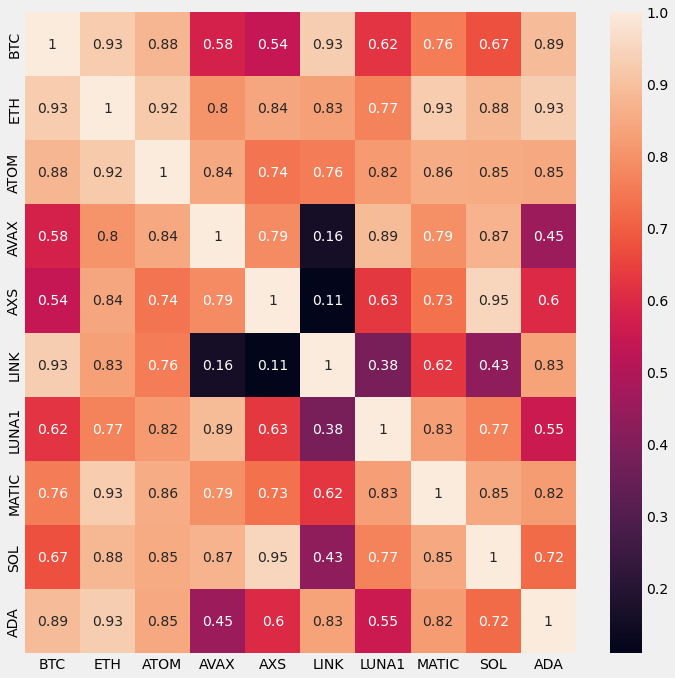

In [142]:
import seaborn as sns
plt.subplots(figsize= (11,11))
sns.heatmap(df.corr(), annot= True)
plt.show()

In [143]:
#import libraries
import plotly.offline as py
import plotly.graph_objs as go

In [144]:
#display the plot inside the notebook.
py.init_notebook_mode(connected=True)

data = [go.Candlestick(x=BTC.Date,
                       open=BTC.open,
                       high=BTC.high,
                       low=BTC.low,
                       close=BTC.close)]

layout = go.Layout(title='Bitcoin Candlestick with Range Slider',
                   xaxis={'rangeslider':{'visible':True}}, height = 800)

fig = go.Figure(data=data,layout=layout)

py.iplot(fig,filename='bitcoin_candlestick')

# Indicators

In [145]:
ADA = ADA.tail(391).set_index('Date')
ATOM = ATOM.tail(391).set_index('Date')
AVAX = AVAX.tail(391).set_index('Date')
AXS = AXS.tail(391).set_index('Date')
BTC = BTC.tail(391).set_index('Date')
ETH = ETH.tail(391).set_index('Date')
LINK = LINK.tail(391).set_index('Date')
LUNA1 = LUNA1.tail(391).set_index('Date')
MATIC = MATIC.tail(391).set_index('Date')
SOL = SOL.tail(391).set_index('Date')

In [146]:
currencies = [ADA, ATOM, AVAX, AXS, BTC, ETH, LINK, LUNA1, MATIC, SOL]

### RSI

In [147]:
for coin in currencies:
    window_length = 14
    coin['diff'] = coin['close'].diff(1)

    # Calculate Avg. Gains/Losses
    coin['gain'] = coin['diff'].clip(lower=0).round(2)
    coin['loss'] = coin['diff'].clip(upper=0).abs().round(2)

    # Get initial Averages
    coin['avg_gain'] = coin['gain'].rolling(window=window_length, min_periods=window_length).mean()[:window_length+1]
    coin['avg_loss'] = coin['loss'].rolling(window=window_length, min_periods=window_length).mean()[:window_length+1]

    # Get WMS averages
    # Average Gains
    for i, row in enumerate(coin['avg_gain'].iloc[window_length+1:]):
        coin['avg_gain'].iloc[i + window_length + 1] =\
            (coin['avg_gain'].iloc[i + window_length] *
             (window_length - 1) +
             coin['gain'].iloc[i + window_length + 1])\
            / window_length
    # Average Losses
    for i, row in enumerate(coin['avg_loss'].iloc[window_length+1:]):
        coin['avg_loss'].iloc[i + window_length + 1] =\
            (coin['avg_loss'].iloc[i + window_length] *
             (window_length - 1) +
             coin['loss'].iloc[i + window_length + 1])\
            / window_length
        
    coin['rsi'] = 100 - (100 / (1.0 + coin['avg_gain'] / coin['avg_loss']))

    coin.drop(['gain','loss','avg_gain', 'avg_loss', 'diff'], axis = 1, inplace = True)

In [148]:
# Import necessary libraries
from plotly.subplots import make_subplots
import plotly.graph_objects as go
# Create Figure
fig = make_subplots(rows=2, cols=1, shared_xaxes=True, row_width=[0.25, 0.75])
df = BTC.copy()

# Create Candlestick chart for price data
fig.add_trace(go.Candlestick(
    x=df.index,
    open=df['open'],
    high=df['high'],
    low=df['low'],
    close=df['close'],
    increasing_line_color='#ff9900',
    decreasing_line_color='black',
    showlegend=False), row=1, col=1)

# Make RSI Plot
fig.add_trace(go.Scatter(
    x=df.index,
    y=df['rsi'],
    line=dict(color='#ff9900', width=2),
    showlegend=False,
), row=2, col=1
)

# Add upper/lower bounds
fig.update_yaxes(range=[-10, 110], row=2, col=1)
fig.add_hline(y=0, col=1, row=2, line_color="#666", line_width=2)
fig.add_hline(y=100, col=1, row=2, line_color="#666", line_width=2)

# Add overbought/oversold
fig.add_hline(y=30, col=1, row=2, line_color='#336699', line_width=2, line_dash='dash')
fig.add_hline(y=70, col=1, row=2, line_color='#336699', line_width=2, line_dash='dash')

# Customize font, colors, hide range slider
layout = go.Layout(
    plot_bgcolor='#efefef',
    # Font Families
    font_family='Monospace',
    font_color='#000000',
    font_size=20,
    xaxis=dict(
        rangeslider=dict(
            visible=False
        )
    )
)
# update and display
fig.update_layout(layout)
fig.show()

### MACD

In [149]:
for coin in currencies:
    # Get the 26-day EMA of the closing price
    k = coin['close'].ewm(span=12, adjust=False, min_periods=12).mean()

    # Get the 12-day EMA of the closing price
    d = coin['close'].ewm(span=26, adjust=False, min_periods=26).mean()

    # Subtract the 26-day EMA from the 12-Day EMA to get the MACD
    macd = k - d

    # Get the 9-Day EMA of the MACD for the Trigger line
    macd_s = macd.ewm(span=9, adjust=False, min_periods=9).mean()

    # Calculate the difference between the MACD - Trigger for the Convergence/Divergence value
    macd_h = macd - macd_s

    # Add all of our new values for the MACD to the dataframe
    coin['macd'] = coin.index.map(macd)
    coin['macd_h'] = coin.index.map(macd_h)
    coin['macd_s'] = coin.index.map(macd_s)

    # View our data
    pd.set_option("display.max_columns", None)
    coin.drop(['macd_h', 'macd_s'], axis = 1, inplace = True)

In [150]:
df = BTC.copy()
# calculate MACD values
df.ta.macd(close='close', fast=12, slow=26, append=True)
# Force lowercase (optional)
df.columns = [x.lower() for x in df.columns]
# Construct a 2 x 1 Plotly figure
fig = make_subplots(rows=2, cols=1)
# price Line
fig.append_trace(
    go.Scatter(
        x=df.index,
        y=df['open'],
        line=dict(color='green', width=1),
        name='open',
        # showlegend=False,
        legendgroup='1',
    ), row=1, col=1
)
# Candlestick chart for pricing
fig.append_trace(
    go.Candlestick(
        x=df.index,
        open=df['open'],
        high=df['high'],
        low=df['low'],
        close=df['close'],
        increasing_line_color='green',
        decreasing_line_color='red',
        showlegend=False
    ), row=1, col=1
)
# Fast Signal (%k)
fig.append_trace(
    go.Scatter(
        x=df.index,
        y=df['macd_12_26_9'],
        line=dict(color='green', width=2),
        name='macd',
        # showlegend=False,
        legendgroup='2',
    ), row=2, col=1
)
# Slow signal (%d)
fig.append_trace(
    go.Scatter(
        x=df.index,
        y=df['macds_12_26_9'],
        line=dict(color='red', width=2),
        # showlegend=False,
        legendgroup='2',
        name='signal'
    ), row=2, col=1
)
# Colorize the histogram values
colors = np.where(df['macdh_12_26_9'] < 0, 'red', 'green')
# Plot the histogram
fig.append_trace(
    go.Bar(
        x=df.index,
        y=df['macdh_12_26_9'],
        name='histogram',
        marker_color=colors,
    ), row=2, col=1
)
# Layout
layout = go.Layout(
    plot_bgcolor='#efefef',
    # Font Families
    font_family='Monospace',
    font_color='#000000',
    font_size=20,
    xaxis=dict(
        rangeslider=dict(
            visible=False
        )
    )
)
# Update options and show plot
fig.update_layout(layout)
fig.show()

In [151]:
#ADA.to_csv('ADA_IND.csv')
#AVAX.to_csv('AVAX_IND.csv')
#ATOM.to_csv('ATOM_IND.csv')
#AXS.to_csv('AXS_IND.csv')
#ETH.to_csv('ETH_IND.csv')
#BTC.to_csv('BTC_IND.csv')
#LINK.to_csv('LINK_IND.csv')
#LUNA1.to_csv('LUNA1_IND.csv')
#MATIC.to_csv('MATIC_IND.csv')
#SOL.to_csv('SOL_IND.csv')

### Stochastic Oscillator

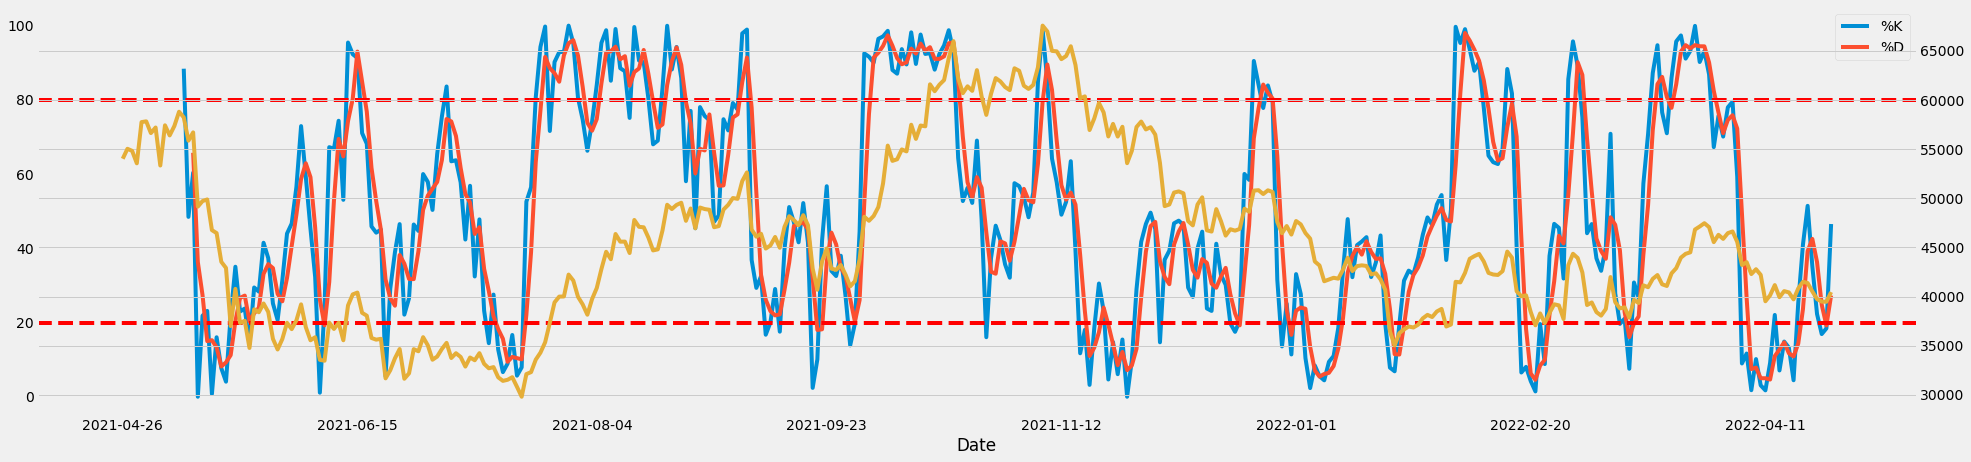

In [152]:
plt.style.use('fivethirtyeight')
BTC_so = BTC.tail(365).copy()

BTC_so['14-high'] = BTC_so['high'].rolling(14).max()
BTC_so['14-low'] = BTC_so['low'].rolling(14).min()
BTC_so['%K'] = (BTC_so['close'] - BTC_so['14-low'])*100/(BTC_so['14-high'] - BTC_so['14-low'])
BTC_so['%D'] = BTC_so['%K'].rolling(3).mean()

ax = BTC_so[['%K', '%D']].plot()
BTC_so['close'].plot(ax=ax, secondary_y=True)
ax.axhline(20, linestyle='--', color="r")
ax.axhline(80, linestyle="--", color="r")
plt.rcParams["figure.figsize"] = (30,7)

plt.show()